In [1]:
import tensorflow as tf
import os


DATA_DIR = 'dataset/car-segmentation'

IMAGE_DIR = os.path.join(DATA_DIR, 'images')
MASK_DIR = os.path.join(DATA_DIR, 'masks')

In [2]:
image_filenames = sorted(os.listdir(IMAGE_DIR))
image_paths = [os.path.join(IMAGE_DIR, fname) for fname in image_filenames]
mask_paths = [os.path.join(MASK_DIR, fname) for fname in image_filenames]


# Create the initial dataset of file path pairs
full_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))


2025-08-24 17:06:44.476980: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-08-24 17:06:44.477005: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-08-24 17:06:44.477008: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1756030004.477361 47105291 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1756030004.477383 47105291 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
DATASET_SIZE = len(image_paths)
TRAIN_SIZE = int(0.8 * DATASET_SIZE) # 80% for training
VAL_SIZE = DATASET_SIZE - TRAIN_SIZE # 20% for validation


full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)

train_dataset = full_dataset.take(TRAIN_SIZE)
val_dataset = full_dataset.skip(TRAIN_SIZE)

print(f"Total examples: {DATASET_SIZE}")
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")

Total examples: 211
Training examples: 168
Validation examples: 43


In [4]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [5]:
def load_and_preprocess(img_path, label_path):
    # 1. Read and decode the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize pixel values to be between 0 and 1
    img = tf.cast(img, tf.float32) / 255.0

    # 2. Read and decode the label (mask)
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    # Use 'nearest' neighbor resizing for masks to avoid creating new class values
    label = tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH], method='nearest')

    return img, label

In [6]:
BATCH_SIZE = 32
BUFFER_SIZE = 200 

In [7]:
train_batches = (
    train_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()  # Cache data for faster subsequent epochs
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat() # Repeat the dataset indefinitely
    .prefetch(buffer_size=tf.data.AUTOTUNE) # Prepares the next batches while the current one is processed
)

In [8]:
val_batches = (
    val_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

2025-08-24 17:06:44.600200: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:06:44.606758: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:06:44.619672: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:06:44.631551: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:06:44.827779: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:06:45.190443: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:06:45.882212: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile



--- Verifying a batch ---
Images batch shape: (32, 128, 128, 3)
Labels batch shape: (32, 128, 128, 1)


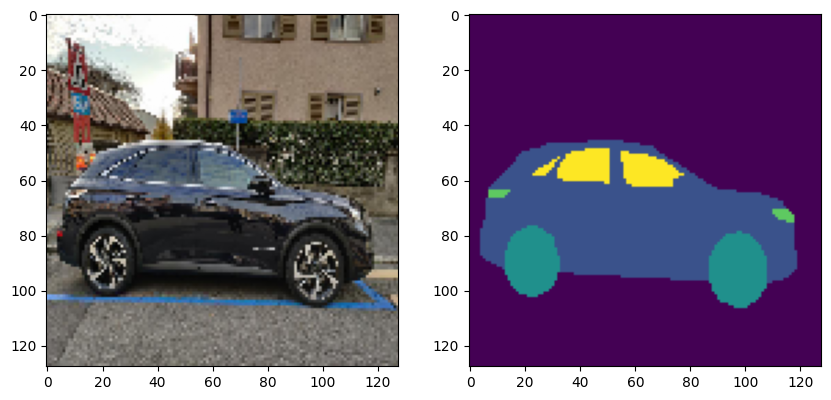

In [9]:
import matplotlib.pyplot as plt
temp_label =None
for images, labels in train_batches.take(1):
    print("\n--- Verifying a batch ---")
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    indx = 0
    
    temp_label = labels[indx]
    axes[0].imshow(images[indx])
    axes[1].imshow(labels[indx],cmap='viridis')
    break
plt.show()

    

In [10]:
import numpy as np
color_value_list = set()
label_numpy = temp_label.numpy()
unique_values = np.unique(label_numpy)
print(unique_values)


for row in range(IMG_WIDTH):
    for col in range(IMG_HEIGHT):
        color_value = label_numpy[row, col][0]
        color_value_list.add(color_value)
        
print(color_value_list) 

[0 1 2 3 4]
{0, 1, 2, 3, 4}


## Build the U-Net Model


In [40]:
import tensorflow as tf
from tensorflow.keras import layers

def build_unet_with_mobilenet(input_shape, num_classes):
    """
    Builds a U-Net model using a pre-trained MobileNetV2 as the encoder.
    (Corrected Version)
    """

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )


    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'out_relu',              # Bottleneck: 4x4
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model (the encoder)
    encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs, name="encoder")
    encoder.trainable = False

    

    #  Build the Decoder Path
    inputs = tf.keras.Input(shape=input_shape)
    skips = encoder(inputs)
    print("#"*30)
    for temp in skips:
        print(temp)

    print("#"*30)
    
    
    x = skips[-1]
    
    decoder_skips = reversed(skips[:-1])

    
    
    print("#"*30)
    for temp in decoder_skips:
        print(temp)
    print("#"*30)
    
    print(x)
    print("#"*30)

    for i, skip in enumerate(decoder_skips):
        x = layers.Conv2DTranspose(filters=512 // (2**i), kernel_size=2, strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters=512 // (2**i), kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters=512 // (2**i), kernel_size=3, padding='same', activation='relu')(x)
    
   

    # It takes the 64x64 feature map and upsamples it to 128x128.
    outputs = layers.Conv2DTranspose(
        filters=num_classes,
        kernel_size=2,
        strides=2,
        padding='same',
        activation='softmax'  # Apply softmax directly here
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [41]:
NUM_CLASSES = 5
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = build_unet_with_mobilenet(input_shape, NUM_CLASSES)
model.summary()

##############################
<KerasTensor shape=(None, 64, 64, 96), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1529>
<KerasTensor shape=(None, 32, 32, 144), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1530>
<KerasTensor shape=(None, 16, 16, 192), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1531>
<KerasTensor shape=(None, 8, 8, 576), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1532>
<KerasTensor shape=(None, 4, 4, 1280), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1533>
##############################
##############################
<KerasTensor shape=(None, 8, 8, 576), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1532>
<KerasTensor shape=(None, 16, 16, 192), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1531>
<KerasTensor shape=(None, 32, 32, 144), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1530>
<KerasTensor shape=(None, 64, 64, 96), dtype=float32, spa

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 64, 64, 96),   │     2,257,984 │
│                                 │ (None, 32, 32, 144),   │               │
│                                 │ (None, 16, 16, 192),   │               │
│                                 │ (None, 8, 8, 576),     │               │
│                                 │ (None, 4, 4, 1280)]    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 8, 8, 5)        │        25,605 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,283,589 (8.71 MB)

 Trainable params: 25,605 (100.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [42]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
EPOCHS = 20
STEPS_PER_EPOCH = len(train_dataset) // BATCH_SIZE
print(STEPS_PER_EPOCH)

5


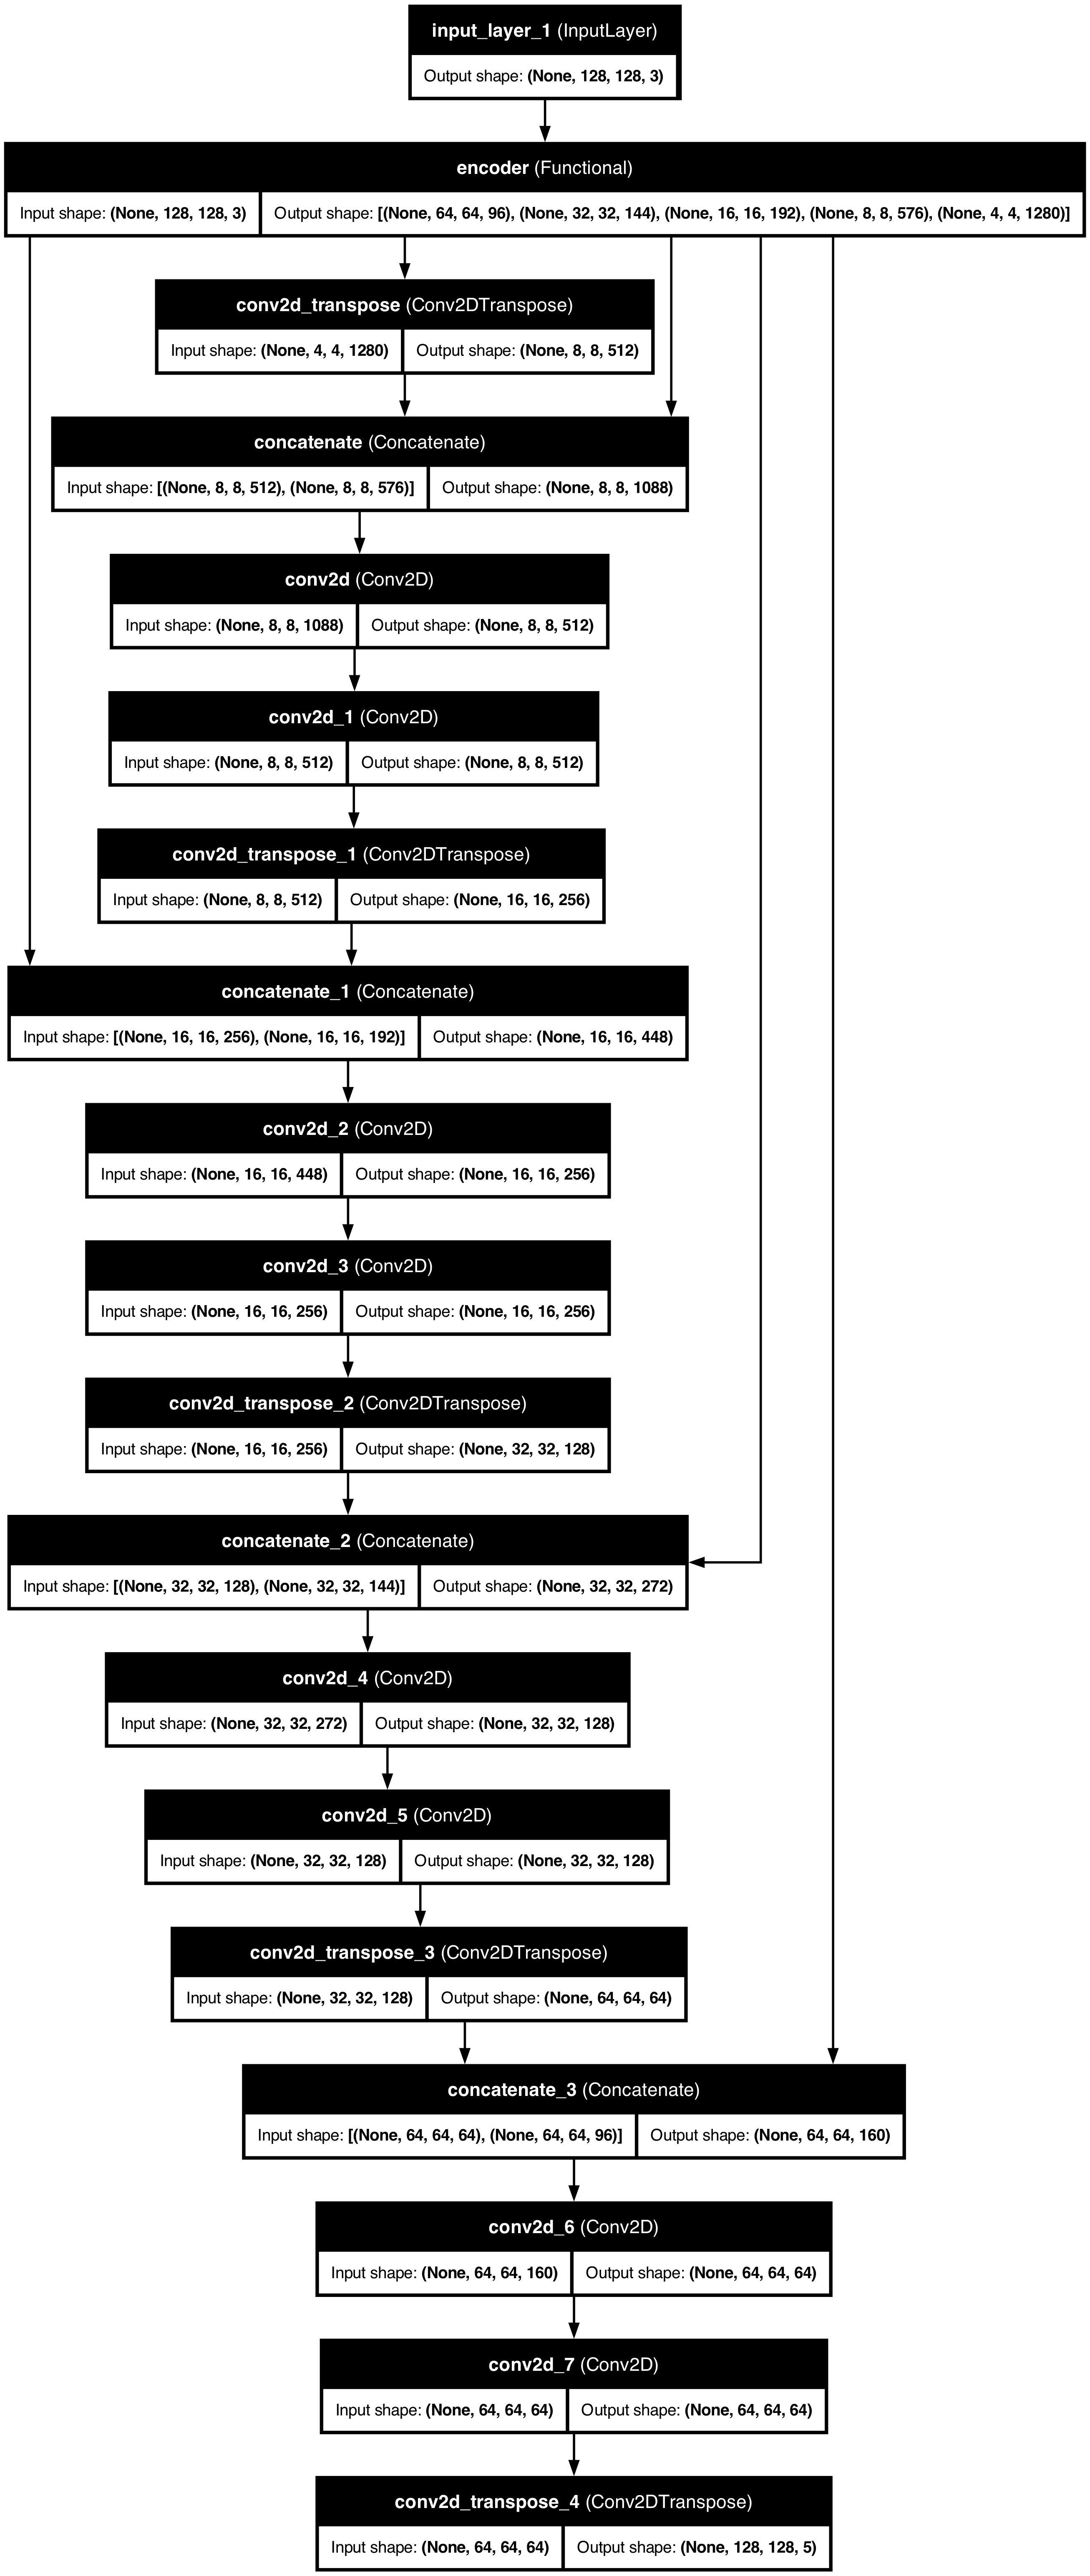

In [28]:
from tensorflow.keras.utils import plot_model

# pip install pydot
# Save model architecture as image
plot_model(model, to_file="tf_lr_model_architecture.png", show_shapes=True, show_layer_names=True)

In [16]:

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6
)

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_batches,
    callbacks=[lr_scheduler]
)

Epoch 1/20


2025-08-24 17:07:17.365254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.4782 - loss: 1.3337

2025-08-24 17:07:21.905871: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:07:21.907607: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 785ms/step - accuracy: 0.4926 - loss: 1.3055 - val_accuracy: 0.6112 - val_loss: 1.0165 - learning_rate: 0.0010
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.6889 - loss: 0.8948 - val_accuracy: 0.8324 - val_loss: 0.5546 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8112 - loss: 0.5930

2025-08-24 17:07:26.067770: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.8106 - loss: 0.5920 - val_accuracy: 0.8033 - val_loss: 0.5851 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8212 - loss: 0.5398

2025-08-24 17:07:27.142786: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:07:27.189725: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 0.8232 - loss: 0.5336 - val_accuracy: 0.8307 - val_loss: 0.5184 - learning_rate: 0.0010
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8489 - loss: 0.4464

2025-08-24 17:07:28.349411: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.8496 - loss: 0.4444 - val_accuracy: 0.8745 - val_loss: 0.3580 - learning_rate: 0.0010
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8667 - loss: 0.3882

2025-08-24 17:07:29.354867: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.8671 - loss: 0.3865 - val_accuracy: 0.8618 - val_loss: 0.4128 - learning_rate: 0.0010
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8730 - loss: 0.3673

2025-08-24 17:07:30.402701: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.8738 - loss: 0.3646 - val_accuracy: 0.8906 - val_loss: 0.3087 - learning_rate: 0.0010
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8731 - loss: 0.3518

2025-08-24 17:07:31.525470: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.8730 - loss: 0.3530 - val_accuracy: 0.8823 - val_loss: 0.3348 - learning_rate: 0.0010
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8849 - loss: 0.3200

2025-08-24 17:07:32.461836: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:07:32.482726: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.8847 - loss: 0.3199 - val_accuracy: 0.8978 - val_loss: 0.2833 - learning_rate: 0.0010
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8918 - loss: 0.2936

2025-08-24 17:07:33.564440: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.8916 - loss: 0.2937 - val_accuracy: 0.8938 - val_loss: 0.2853 - learning_rate: 0.0010
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9028 - loss: 0.2569

2025-08-24 17:07:34.581890: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:07:34.584825: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:07:34.599664: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:07:34.640883: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.9029 - loss: 0.2558 - val_accuracy: 0.9042 - val_loss: 0.2324 - learning_rate: 0.0010
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9032 - loss: 0.2385

2025-08-24 17:07:35.627938: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:07:35.652659: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.9039 - loss: 0.2373 - val_accuracy: 0.9175 - val_loss: 0.2090 - learning_rate: 0.0010
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9201 - loss: 0.2040

2025-08-24 17:07:36.568398: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:07:36.575628: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.9204 - loss: 0.2040 - val_accuracy: 0.9195 - val_loss: 0.2119 - learning_rate: 0.0010
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9279 - loss: 0.1890

2025-08-24 17:07:37.665547: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:07:37.667848: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:07:37.707293: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.9283 - loss: 0.1880 - val_accuracy: 0.9380 - val_loss: 0.1614 - learning_rate: 0.0010
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.9330 - loss: 0.1780 - val_accuracy: 0.9355 - val_loss: 0.1699 - learning_rate: 0.0010
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9419 - loss: 0.1561

2025-08-24 17:07:39.698453: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.9419 - loss: 0.1560 - val_accuracy: 0.9407 - val_loss: 0.1551 - learning_rate: 0.0010
Epoch 17/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9439 - loss: 0.1469

2025-08-24 17:07:40.825781: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:07:40.884787: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.9436 - loss: 0.1477 - val_accuracy: 0.9299 - val_loss: 0.1863 - learning_rate: 0.0010
Epoch 18/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9474 - loss: 0.1380

2025-08-24 17:07:41.925743: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:07:41.936835: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.9473 - loss: 0.1383 - val_accuracy: 0.9509 - val_loss: 0.1294 - learning_rate: 0.0010
Epoch 19/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9481 - loss: 0.1358

2025-08-24 17:07:42.963233: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.9483 - loss: 0.1351 - val_accuracy: 0.9462 - val_loss: 0.1415 - learning_rate: 0.0010
Epoch 20/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9532 - loss: 0.1217

2025-08-24 17:07:43.924140: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-24 17:07:43.937442: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.9532 - loss: 0.1217 - val_accuracy: 0.9519 - val_loss: 0.1269 - learning_rate: 0.0010


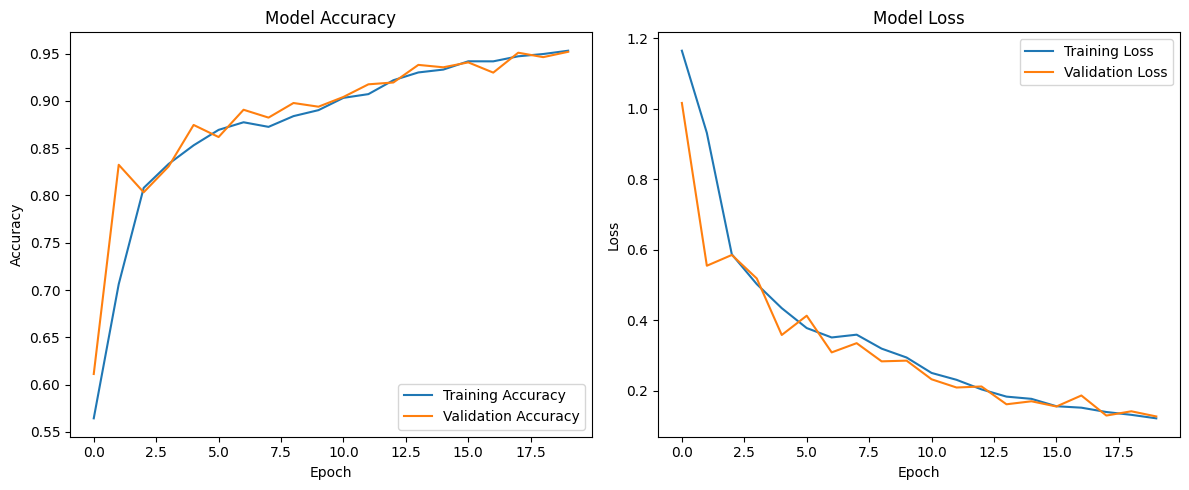

In [17]:
import matplotlib.pyplot as plt


has_validation_data = 'val_loss' in history.history


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if has_validation_data:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if has_validation_data:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [18]:
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(val_batches)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating model on the test set...


2025-08-24 17:07:44.702506: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9605 - loss: 0.1011 

Test Loss: 0.1005
Test Accuracy: 0.9607


### Model Saving and Prediction

In [19]:
model.save('models/car_segmentation_unet.keras')

In [20]:
loaded_model = tf.keras.models.load_model('models/car_segmentation_unet.keras')

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [22]:
def model_predict(image_path, model):
    # This must be IDENTICAL to your training preprocessing
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img_normalized = tf.cast(img, tf.float32) / 255.0
    

    img_batch = tf.expand_dims(img_normalized, axis=0)

    # Predict
    predicted_masks = model.predict(img_batch)
    return predicted_masks , img
    

In [23]:
def predict_and_visualize(image_path, model):

   
    predicted_masks,img = model_predict(image_path, model)

    # The output is (1, H, W, num_classes).
    #  We take the argmax along the
    # class axis to get the final mask (1, H, W).
    pred_mask = tf.argmax(predicted_masks, axis=-1)
    
    # Remove the batch dimension to get a displayable image (H, W)
    pred_mask = pred_mask[0]
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    # Display the original, un-normalized image
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask)
    plt.axis('off')
    
    plt.show()

2025-08-24 17:07:46.437650: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


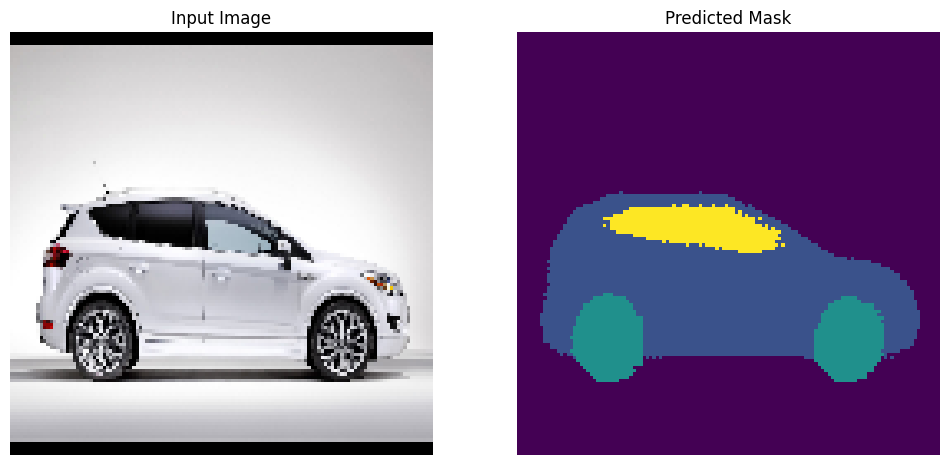

In [24]:
test_path = "dataset/car-segmentation/images/2009-Ford-Kuga-Show-Car-Side-1280x960.png"
#test_path = "dataset/car-segmentation/images/003.png"

predict_and_visualize(test_path, loaded_model)

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show_all_masks(image_path, model, class_encodings):
    """
    Loads an image, gets a prediction, and displays the probability
    mask for every individual class.
    """
    predicted_masks,img = model_predict(image_path, model)

    
    # --- 3. Visualize the Input and All Masks ---
    num_classes = model.output_shape[-1]
    
    # Create a figure to display the results
    # We need 1 spot for the input image + num_classes spots for the masks
    plt.figure(figsize=(15, 4 * (num_classes // 3 + 1)))
    
    # Plot the input image
    plt.subplot(2, 3, 1)
    plt.title("Input Image")
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')
    
    # Loop through each class and plot its probability mask
    for i in range(num_classes):
        # Extract the mask for the i-th class
        class_mask = predicted_masks[0, :, :, i]
        
        # Get the class name from our encodings dictionary
        # JSON keys are strings, so we convert the index `i` to a string
        class_name = class_encodings.get(str(i), f"Class {i}")
        
        plt.subplot(2, 3, i + 2)
        plt.title(f"Mask: {class_name}")
        # Display the mask as a heatmap. 'viridis' is a good colormap for this.
        plt.imshow(class_mask, cmap='viridis') 
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2025-08-24 17:07:48.073057: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


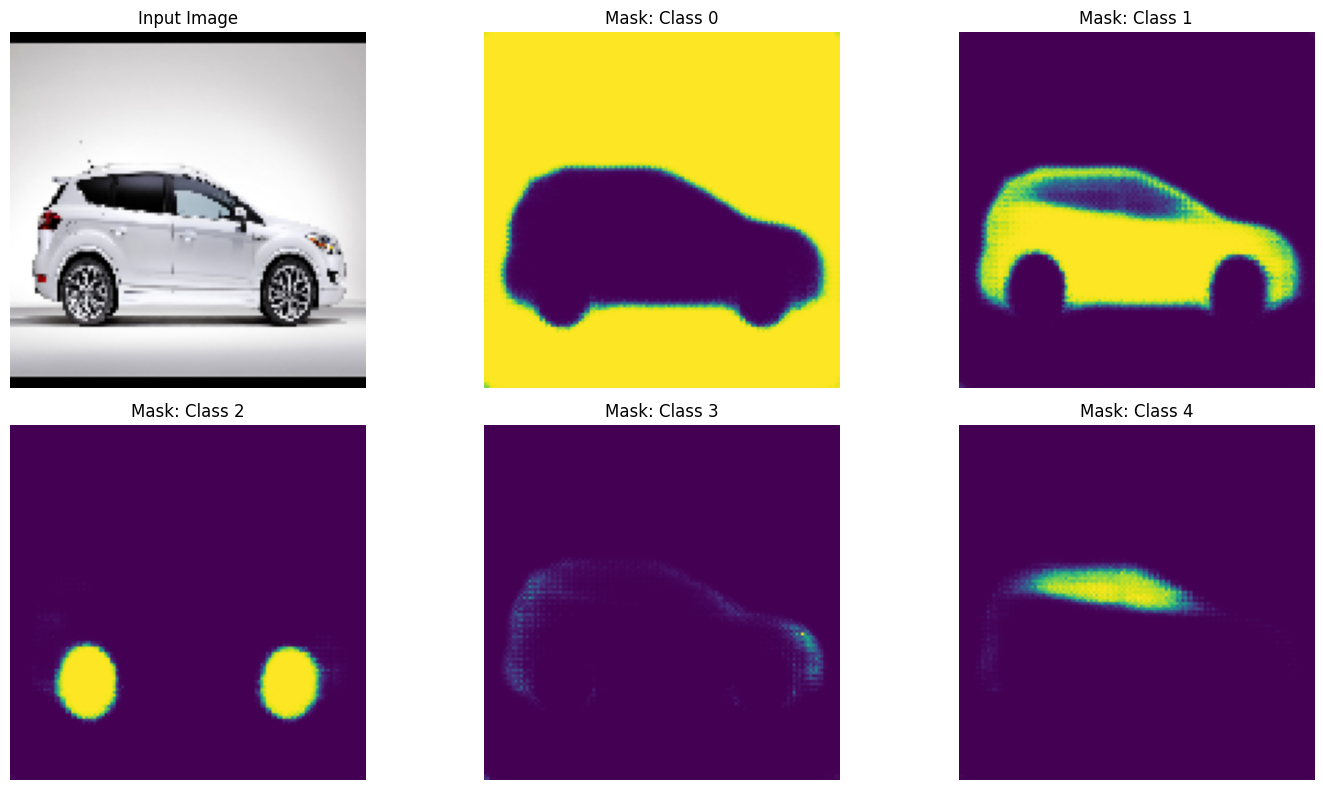

In [26]:
generic_encodings = {str(i): f"Class {i}" for i in range(NUM_CLASSES)}

predict_and_show_all_masks(test_path, loaded_model, generic_encodings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2025-08-24 17:07:48.536323: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


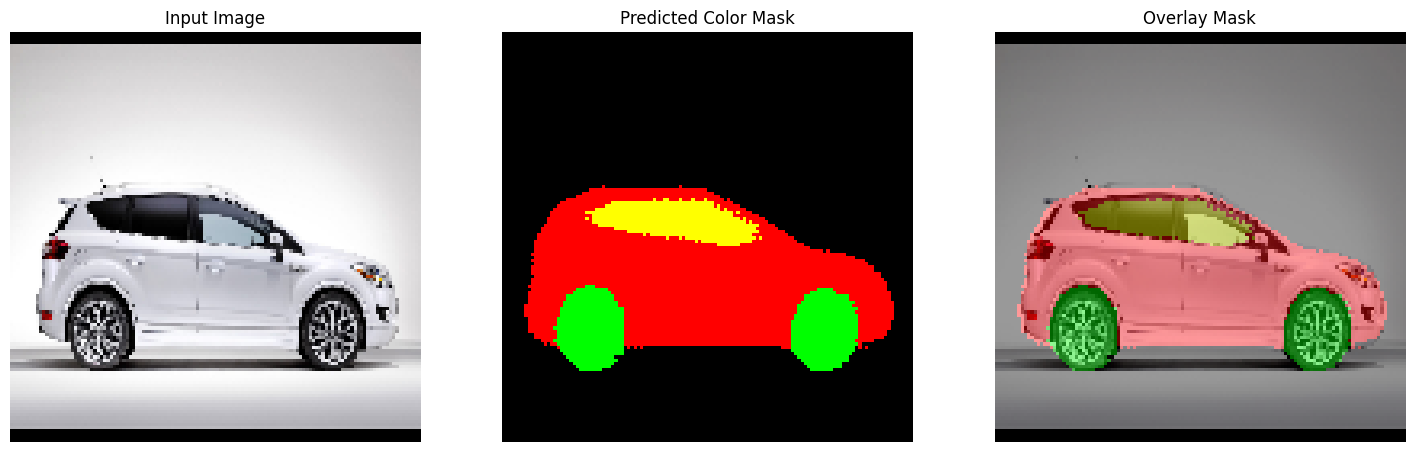

In [27]:
import numpy as np
import cv2 

# 1. Define a color for each of your 5 classes (0 to 4)
COLOR_MAP = np.array([
    [0, 0, 0],       # Class 0: Black (e.g., background)
    [255, 0, 0],     # Class 1: Red
    [0, 255, 0],     # Class 2: Green
    [0, 0, 255],     # Class 3: Blue
    [255, 255, 0]    # Class 4: Yellow
], dtype=np.uint8)

def mask_to_rgb(mask, color_map):
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_idx, color in enumerate(color_map):
        rgb_mask[mask == class_idx] = color
    return rgb_mask


def predict_and_visualize_color(image_path, model, color_map):
    predicted_masks, img = model_predict(image_path, model)
    pred_mask = tf.argmax(predicted_masks, axis=-1)[0].numpy()
    
    # Convert mask to color
    color_mask = mask_to_rgb(pred_mask, color_map)
    
    # Convert original image tensor for display
    input_image_numpy = tf.keras.utils.img_to_array(img, dtype=np.uint8)
    
    # Blend the input image and the color mask for an overlay effect
    overlay = cv2.addWeighted(input_image_numpy, 0.6, color_mask, 0.4, 0)
    
    # Display the results
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image_numpy)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Predicted Color Mask")
    plt.imshow(color_mask)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Overlay Mask")
    plt.imshow(overlay)
    plt.axis('off')
    
    plt.show()


test_path = "dataset/car-segmentation/images/2009-Ford-Kuga-Show-Car-Side-1280x960.png"
predict_and_visualize_color(test_path, loaded_model, COLOR_MAP)